In [3]:
%pylab inline
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import theano.tensor as T
import theano
plt.style.use(['seaborn-talk'])
plt.rcParams["figure.figsize"] = (10,8)
print(pm.__version__)
print(theano.__version__)

Populating the interactive namespace from numpy and matplotlib
3.5
1.0.2


In [33]:
c_light ="#DCBCBC"
c_light_highlight ="#C79999"
c_mid ="#B97C7C"
c_mid_highlight ="#A25050"
c_dark ="#8F2727"
c_dark_highlight ="#7C0000"

In [126]:
generative_ensemble2 = pm.Model()

N = 1000
R = 1000

with generative_ensemble2:
    theta = pm.Beta(name="theta", alpha = 1, beta = 1)
    lambda_ = pm.HalfNormal(name="lambda", sd = 6.44787)
    
    failure = pm.Bernoulli(name="failure", p=theta, shape = (N,))
    rate = pm.Poisson(name="rate", mu = lambda_, shape = (N,))
        
    y = pm.Deterministic("y", rate * (1 - failure))

In [127]:
with generative_ensemble2:
    trace = pm.sample_prior_predictive(samples=R)

In [128]:
trace["failure"]

array([[0, 1, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 0, ..., 0, 0, 0]])

In [131]:
trace["theta"][:10]

array([0.91163146, 0.77897613, 0.04778361, 0.04745637, 0.44676625,
       0.15147869, 0.65363818, 0.68514502, 0.73831171, 0.57090904])

In [132]:
trace["lambda"][:10]

array([ 4.41818282,  4.23146037,  1.76734282,  8.89393277,  0.24634094,
        4.25726717,  1.753186  , 14.26473381,  3.95300948,  2.65644416])

In [133]:
simu_ys = trace["y"]
simu_ys

array([[5, 0, 1, ..., 0, 2, 0],
       [4, 0, 4, ..., 6, 7, 0],
       [4, 0, 2, ..., 5, 5, 4],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 4],
       [0, 0, 5, ..., 3, 8, 5]])

In [134]:
np.count_nonzero(simu_ys, axis=0).std()

277.44220255577557

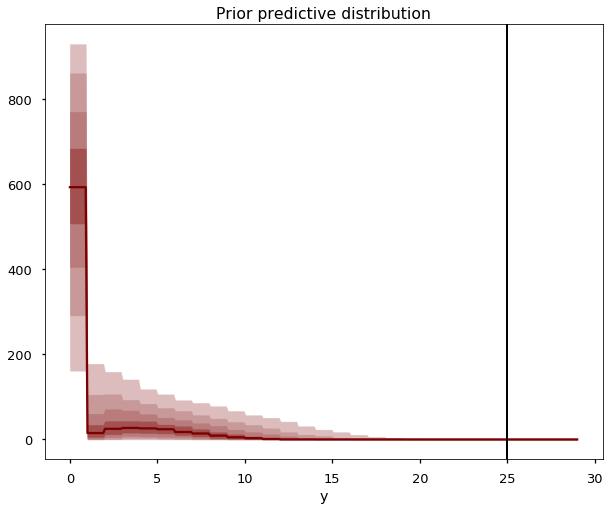

In [135]:
x_max = 30
bins = np.arange(0 ,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, simu_ys.T)

prctiles = np.percentile(hists,np.linspace(10, 90,num=9),axis=0)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

for i, color in enumerate([c_light, c_light_highlight, c_mid, c_mid_highlight]):
    plt.fill_between(bin_interp, prctiles_interp[i, :],
                     prctiles_interp[-1 - i, :],
                     alpha = 1.0,
                     color = color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Prior predictive distribution');